<a href="https://colab.research.google.com/github/jungsh210/AI-Project/blob/main/SAM/SAM_Tutorial_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anyting 모델 미세조정하기 - SAM

- 컴퓨터 비전은 지난 주 메타(Meta)의 Segment Anything Model(SAM)의 출시와 함게 ChatGPT의 순간을 맞이하고 있습니다.
- 110억 개 이상의 Segmentation mask를 학습한 SAM은 생성형 AI가 아닌 예측형 AI 사용 사례를 위한 기반 모델입니다.
- 광범위한 이미지 양식과 문제 공간을 세분화하는 능력에서 놀라운 유연성을 보여줬지만, '미세 조정' 기능 없이 출시되었습니다.

- 이 tutorial에서는 mask decoder를 사용하여 SAM을 미세 조정하는 몇 가지 주요 단계를 설명합니다.
- 특히 미세 조정에 적합한 상태가 되도록 데이터를 사전/사후 처리하는 데 SAM의 어떤 기능을 사용해야 하는지에 대해 설명합니다.

# Segment Anything Model(SAM)이란 무엇인가?

- Segment Anything Model(SAM)은 메타 AI에서 개발한 세분화 모델
- 컴퓨터 비전을 위한 최초의 foundation model로 간주
- SAM은 수백만 개의 이미지와 수십억 개의 마스크가 포함된 방대한 데이터 코퍼스를 학습하여 매우 강력
- 이름에서 알 수 있듯이 SAM은 다양한 이미지에 대해 정확한 분할 마스크를 생성할 수 있음
- SAM은 사람의 프롬프트를 고려할 수 있도록 설계되어, 사람이 개입한 어노테이션(Human in the Loop annotation) 작업 시 특히 강력하게 동작
- 이러한 프롬프트는 분할할 영역의 점, 분할할 오브젝트 주변의 경계 상자 또는 분할해야 할 내용에 대한텍스트 프롬프트 등 다양한 모드로 표시됨

- 이 모델은 이미지 인코더, 프롬프트 인코더, 마스크 디코더의 세 가지 요소로 구성

### 이미지 인코더
- segment되는 이미지에 대한 임베딩(embedding)을 생성

### 프롬프트 인코더
- 프롬프트에 대한 임베딩(embedding)을 생성

### 마스크 디코더
- 모델에서 특히 큰 부분을 차지하는 구성요소
- 임베딩(embedding)을 기반으로 segmentation mask를 예측하는 경량 마스크 디코더와 대조되는 부분

# 모델 미세 조정이란?
- 사전 학습된 모델(아키텍쳐 + 가중치)을 가져와 특정 사용 사례에 대한 데이터를 학습시키는 프로세서
- 모델을 미세 조정하는 것과 처음부터 시작하는 것의 차이점은 가중치(weight)과 편향(bias)의 시작 값이다.
- 이러한 값은 특정 전략에 따라 무작위로 초기화
- 시작 구성에서는 모델이 처리해야할 작업에 대해 '아무것도 모르기 때문에' 성능이 저하
- 기존의 가중치와 편향을 시작점으로 사용하면 가중치와 편향을 '미세 조정'하여 모델이 사용자 지정 데이터 세트에서 더 잘 작동하도록 할 수 있음

# 모델을 미세 조정하는 이유
- 사전 학습된 모델이 이전에 보지 못했던 데이터에서 더 높은 성능을 얻기 위한 것
- 예)
    - 휴대폰 카메라에서 수집한 데이터로 학습된 이미지 분할 모델은 대부분 수평 관점에서 이미지를 보았을 것이다.
    - 이 모델을 수직 관점에서 촬영한 위성 이미지에 사용하려고 하면 성능이 좋지 않을 것이다.
- 사전 학습은 모델이 일반적으로 물체를 세그먼트하는 방법을 학습했기 때문에 유용
- 이 시작점을 활용하여 지붕을 정확하게 세분화할 수 있는 모델을 구축하고자 한다.
- 또한 사용자 지정 데이터 세트에는 수백만 개의 예가 없을 가능성이 높으므로 모델을 처음부터 학습시키는 대신 미세 조정을 하고자 한다.

- 모델을 처음부터 학습시키는 연산 비용을 들이지 않고도 특정 사용 사례에서 더 나은 성능을 얻을 수 있도록 미세 조정을 하는 것이 바람직하다.

# SAM이 해결한 기존 문제
- SAM 이전의 이미지 분할 방식에는 단 두 가지가 존재
  - 첫 번째는 대화형 분할(Interactive Segmentation)로 이는 모든 종류의 사물을 분할할 수 있지만, 인간이 마스크(Mask)를 반복적으로 다듬어서 가이드를 제공해야 한다는 한계점
  - 두 번째는 자동 분할(Automatic Segmentation)의 경우, 미리 정의된 특정 사물의 카테코리(ex. 고양이, 의자 등)을 분할할 수 있지만, 엄청난 양의 사물 이미지를 학습해야 한다는 한계점

- SAM은 이 두 가지의 한계점을 일반화
- 대화형 분할과 자동 분할을 동시에 수행할 수 있는 단일 모델인 것이다.
- 일반화를 했다는 말은, 실무자가 더 이상 직접 분할 데이터를 수집하고 사용 사례에 맞게 모델을 미세 조정할 필요가 없다는 것을 의미

## SAM의 기능
- 어떤 사물이든 클릭 한 번으로 이미지를 분할하여 사물을 포함하거나 제외하는 것이 가능
- 분할 대상 사물이 모호한 경우에, 여러 개의 유효한 마스크를 출력
- 이미지 내의 모든 사물을 자동으로 찾아서 마스킹
- 실시간으로 입력된 정보를 바탕으로 이미지를 분할하기 때문에, 사용자는 입력한 정보에 따라 이미지가 어떻게 분리되는지를 빠르게 확인

## SAM의 작동 원리

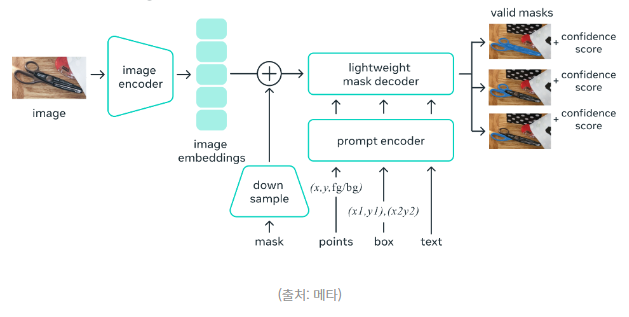

# 시작하기 전에
- GPU에 액세스할 수 있는지 확인합니다.
- nvidia-smi 명령어 사용
- 문제가 있는 경우 수정 -> 노트북 설정 -> 하드웨어 가속기로 이동하여 GPU로 설정한 다음 저장을 클릭

In [1]:
!nvidia-smi

Wed Jul  5 06:07:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**참고**
- 데이터 세트, 이미지 및 모델을 더 쉽게 관리할 수 있도록 'HOME' 상수를 만듭니다.

In [12]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
import os   # 'os' 모듈 import
HOME = os.getcwd()  # 현재 작업 디렉토리의 경로를 얻고, 'HOME' 변수에 저장
print("HOME:", HOME)  # 'HOME' 변수의 값을 출력

# 출력 결과 : 현재 작업 디렉토리의 경로 확인 가능

## SAM(Segment Anything Model) 및 기타 종속성 설치

In [14]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lkny6f97
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lkny6f97
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
%cd {HOME}   # 현재 디렉토리를 'HOME' 변수로 변경

import sys    # 'sys' 모듈 import

# 시스템의 파이썬 실행 파일을 사용하여 pip 명령어를 실행하여 segment-anything 패키지를 설치
# '-m pip install'을 실행하고, 'git+https://github.com/facebookresearch/segment-anything.git'을 통해
# GitHub 저장소에서 'segment-anything' 패키지를 설치

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [15]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [10]:
# '-q': 출력을 조용하게 만들어 상세한 정보를 표시X
# 'jupyter_bbox_widget', 'roboflow', 'dataclasses-json', 'supervision' 패키지를 설치
# 패키지 이름 뒤에 버전 번호가 없는 경우, 기본적으로 최신 버전의 패키지가 설치

!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

## Download SAM weights

In [16]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights


In [ ]:
%cd {HOME}
!mkdir {HOME}/weights   # {HOME}/weights 디렉토리 생성, 해당 디렉토리로 작업 디렉토리 변경
%cd {HOME}/weights      # 작업 디렉토리를 생성한 'weights' 디렉토리로 변경하는 명령어

# 'wget'을 사용하여 주어진 URL에서 파일을 다운로드 하는 명령어
# '-q' 옵션은 조용한 모드로 실행하는 것을 의미
# 가중치 파일을 다운로드 하는 코드
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [17]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import os    # os를 import : 운영 체제와 상호 작용하기 위한 기능을 제공

# os.path.join() 함수를 사용하여 'HOME', 'weights', 'sam_vit_g_4b8939.pth'를 연결하여 파일 경로를 생성
# os.path.join() 함수는 운영 체제에 맞게 경로를 연결
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

# 생성된 파일 경로와 해당 파일의 존재 여부를 출력
# os.path.isfile() 함수는 주어진 경로가 파일인지 여부를 확인하는 함수
# 이를 통해 파일의 존재 여부를 확인하고 출력
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

## Download Example Data
- 몇 가지 예시 이미지를 다운

In [18]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/content
/content/data


In [ ]:
%cd {HOME}           # 현재 작업 디렉토리를 'HOME'으로 변경하는 명령어
!mkdir {HOME}/data   # 'HOME' 디렉토리 내에 'data' 디렉토리를 생성하는 명령어
%cd {HOME}/data      # 작업 디렉토리를 'data; 디렉토리로 변경하는 명령어

# 'wget'을 사용하여 주어진 URL에서 파일을 다운로드 하는 명령어
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

## Load Model

In [19]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
import torch # Pytorch 라이브러리를 import

# torch.cuda.is_available() 함수를 사용하여 CUDA가 사용 가능한 경우 GPU 디바이스를 선택하고,
# 그렇지 않은 경우 CPU를 선택
# 이렇게 선택된 디바이스를 DEVICE 변수에 할당.
# CUDA가 사용 가능한 경우 cuda:0을, 사용할 수 없는 경우 cpu를 할당.

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# MODEL_TYPE = "vit_h": 모델 유형을 나타내는 문자열 "vit_h"를 MODEL_TYPE 변수에 할당합니다.
MODEL_TYPE = "vit_h"

In [20]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [ ]:
# segment_anything 라이브러리에서 sam_model_registry, SamAutomaticMaskGenerator, SamPredictor 모듈을 import
# 이 모듈들은 SAM 모델과 관련된 클래스와 함수를 제공합니다.
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_model_registry에서 MODEL_TYPE에 해당하는 SAM 모델을 선택하여 초기화
# checkpoint=CHECKPOINT_PATH는 CHECKPOINT_PATH에 저장된 가중치 파일을 사용하여 모델을 초기화한다는 것을 의미
# 그리고 to(device=DEVICE)를 사용하여 모델을 DEVICE에 할당
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation
- 자동 마스크 생성을 실행하려면 SamAutomaticMaskGenerator 클래스에 SAM 모델을 제공
- 아래 경로를 SAM 체크포인트로 설정
- CUDA에서 기본 모델로 실행하는 것이 베스트

In [21]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
# SamAutomaticMaskGenerator 클래스를 사용하여 sam 모델을 이용한 자동 마스크 생성기(mask_generator)를 초기화하는 작업
# SamAutomaticMaskGenerator 클래스의 인스턴스를 생성하고, 생성된 인스턴스에 sam 모델을 전달하여 초기화
# mask_generator는 sam 모델을 사용하여 자동으로 마스크를 생성할 수 있는 기능을 제공

mask_generator = SamAutomaticMaskGenerator(sam)

In [22]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [ ]:
import os    # 'os' 모듈 import

IMAGE_NAME = "dog.jpeg"     # 이미지 파일 이름을 'dog.jpeg'로 설정

# 'os.path.join()' 함수를 사용하여 'HOME', 'data', 'dog.jpeg'를 연결하여 이미지 파일 경로를 생성
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

## SAM으로 마스크생성

In [23]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [ ]:
import cv2   # 'cv2' 모듈 import
import supervision as sv   # 'supervision' 모듈 import

image_bgr = cv2.imread(IMAGE_PATH)   # 'cv2.imread()' 함수에 'IMAGE_PATH' 전달하여 이미지를 BGR 색상 공간으로 로드

# cv2.cvtColor() 함수를 사용하여 BGR 색상 공간으로 로드한 이미지를 RGB 색상 공간으로 변환
# OpenCV에서 이미지는 기본적으로 BGR 순서로 저장되며, RGB 순서로 사용하고자 할 때 이러한 변환 작업이 필요
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# mask_generator라는 객체 또는 함수를 사용하여 image_rgb에 대한 마스크를 생성
sam_result = mask_generator.generate(image_rgb)

## 출력 형식(Output format)

- SamAutomaticMaskGenerator는 마스크 목록을 반환합니다. 여기서 각 마스크는 마스크에 대한 다양한 정보를 포함하는 사전입니다.
- `segmentation` - [np.array] - `(W,H)` 모양 및 `bool 유형`의 마스크
- `area` - [int] - 마스크 영역(픽셀 단위)
- `bbox` - [List[int]] - `xywh` 형식의 마스크 경계 상자
- `predicted_iou` - [float] - 마스크 품질에 대한 모델 자체 예측
- `point_coords` - [List[List[float]]] - 이 마스크를 생성한 샘플링된 입력 포인트
- `stability_score` - [float] - 마스크 품질의 추가 측정
- `crop_box` - List[int] - `xywh` 형식으로 이 마스크를 생성하는 데 사용되는 이미지 자르기

In [24]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
# sam_result 변수의 [0] 인덱스에 해당하는 요소의 키를 출력
# sam_result 변수는 이전 코드에서 mask_generator.generate(image_rgb)를 통해 생성된 결과를 저장하는 변수

print(sam_result[0].keys())

## Supervision을 통한 결과 시각화
- 버전 '0.5.0'부터 Supervision은 SAM을 기본적으로 지원

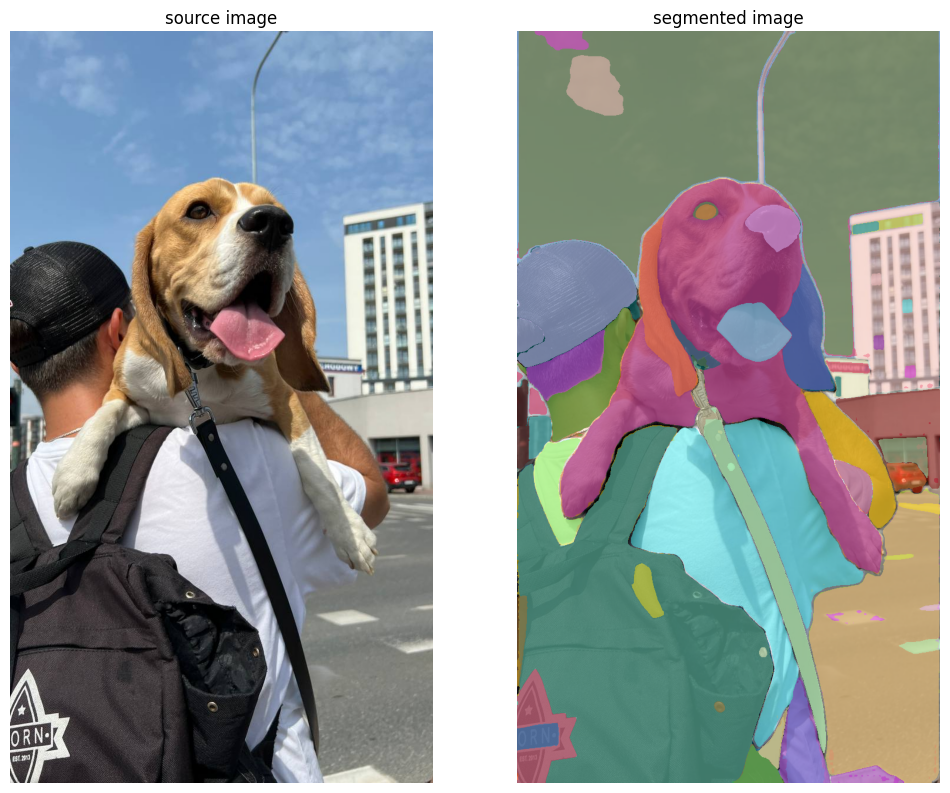

In [25]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
# sv.MaskAnnotator() 클래스의 인스턴스를 mask_annotator라는 변수에 할당
mask_annotator = sv.MaskAnnotator()

# sv.Detections.from_sam() 함수를 사용하여 sam_result를 기반으로 detections 변수를 생성
# sam_result를 입력으로 받아 이미지 내에서 감지된 개체 또는 특징을 나타내는 Detections 객체를 반환
detections = sv.Detections.from_sam(sam_result=sam_result)

# mask_annotator 객체의 annotate() 메서드를 호출하여
# image_bgr에 대한 주석이 추가된 이미지를 생성하고 annotated_image 변수에 저장
# 원본 이미지(image_bgr.copy())와 detections를 인자로 전달
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# sv.plot_images_grid() 함수를 호출하여 이미지를 그리드 형태로 플로팅
# 이 함수는 이미지 리스트(images), 그리드 크기(grid_size), 그리드 내 이미지에 대한 제목(titles)을 인자 받
# image_bgr과 annotated_image를 인자로 전달하고,
# 그리드 크기는 (1, 2)로 지정하고 있으며,
# 이미지에 대한 제목은 'source image'와 'segmented image'로 지정
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## 분할 결과와의 상호 작용

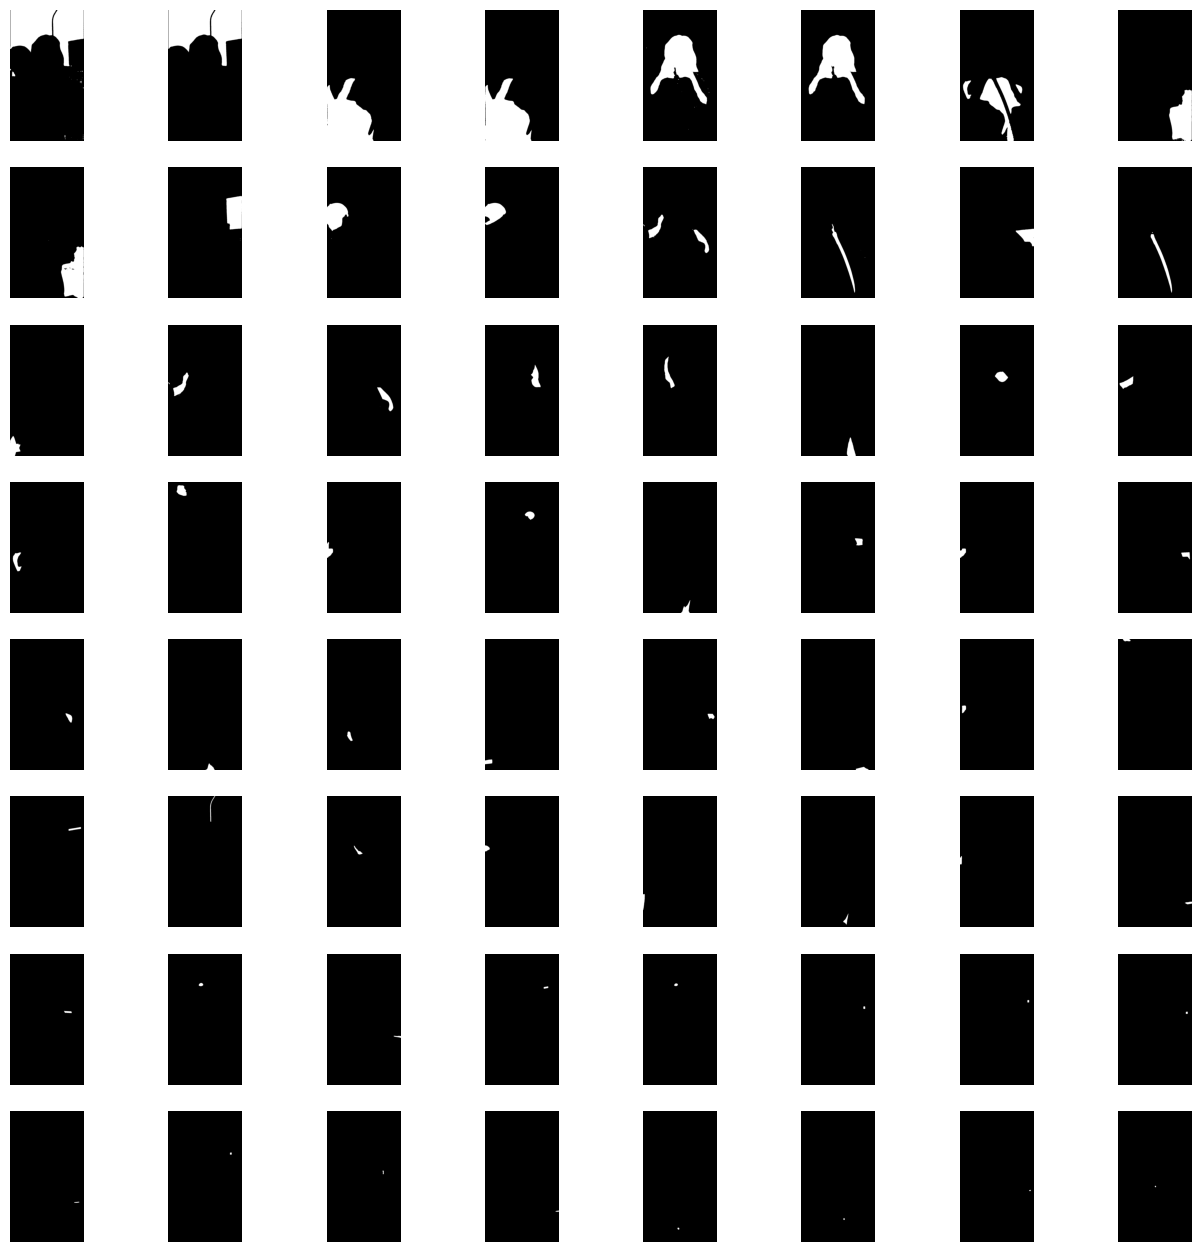

In [26]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

In [ ]:
# sam_result를 area 키를 기준으로 내림차순으로 정렬
# 분할 정보를 추출하여 masks 리스트에 저장하는 작업
# 리스트 컴프리헨션을 사용하여 sam_result의 각 요소에 대해 mask['segmentation']을 추출하고, 이를 masks 리스트에 저장
# masks는 sam_result에서 분할 정보만을 담은 리스트

masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

# sv.plot_images_grid() 함수를 호출하여 masks 리스트를 그리드 형태로 플로팅
# images 인자에 masks를 전달
# 그리드 크기는 (8, int(len(masks) / 8))로 지정
# 플로팅된 그리드의 크기는 (16, 16)로 설정

sv.plot_images_grid(      # vit_b 모델은 에러 발생, vit_b : 작은 모델, vit_h : 큰 모델
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

## 경계 상자로 분할 생성
- 'SamPredictor' 클래스는 모델 프롬프트를 위한 모델에 대한 쉬운 인터페이스를 제공합니다. 필요한 이미지 임베딩을 계산하는 'set_image' 메서드를 사용하여 사용자가 먼저 이미지를 설정할 수 있습니다. 그런 다음 'predict' 메서드를 통해 프롬프트를 제공하여 해당 프롬프트에서 마스크를 효율적으로 예측할 수 있습니다. 모델은 포인트 및 상자 프롬프트와 이전 예측 반복의 마스크를 모두 입력으로 사용할 수 있습니다.

In [27]:
mask_predictor = SamPredictor(sam)

In [ ]:
# 'SamPredictor'라는 클래스의 객체를 생성하고, 이를 'mask_predictor' 변수에 할당
# 생성자 호출 시에 'sam'을 인자로 전달

mask_predictor = SamPredictor(sam)

In [28]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [ ]:
import os    # 'os' 모듈 import

IMAGE_NAME = "dog.jpeg"    # 'IMAGE_NAME' 변수에 "dog.jpeg"라는 이미지 파일의 이름을 할당
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)   # os.path.join() 함수를 사용하여 이미지 파일의 전체 경로를 생성
                                                      # HOME, "data", IMAGE_NAME을 조합하여 이미지 파일의 전체 경로를 생성

## Draw Box

In [29]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
# helper function that loads an image before adding it to the widget

# 'base64' 라이브러리를 import
# 'base64' 모듈은 데이터를 base64로 인코딩하거나 디코딩하는 기능을 제공
import base64

# encode_image()라는 함수를 정의
# filepath라는 인자를 받고, 이 함수는 이미지 파일의 경로를 인자로 받아 처리
def encode_image(filepath):
    with open(filepath, 'rb') as f:  # 'filepath'로 전달된 이미지 파일을 이진(binary) 모드로 열기 위해 'open()' 함수를 사용
                                     # 'rb' 모드를 사용하여 파일을 읽기(read) 전용으로 열고, 파일 객체를 'f'라는 변수에 할당
        image_bytes = f.read()       # 이미지 파일을 이진 모드로 열었으므로,
                                     # 'read()' 메서드를 사용하여 이미지 파일의 모든 바이트를 읽어 'image_bytes' 변수에 저장
    encoded = str(base64.b64encode(image_bytes), 'utf-8')   # 'base64.b64encode()' 함수를 사용하여 'image_bytes'를 base64로 인코딩
                                                            #  인코딩된 결과를 문자열로 변환하고, 인코딩된 문자열을 'encoded' 변수에 할당
    return "data:image/jpg;base64,"+encoded    # 인코딩된 이미지 데이터를 "data:image/jpg;base64,"와 결합하여 이미지 데이터 URI 형식으로 반환

** 참고 **
- 아래 셀을 실행하고 마우스를 사용하여 이미지에 테두리 상자를 그립니다.

In [30]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
IS_COLAB = True  # IS_COLAB 변수에 True를 할당하여, 코드가 Google Colab 환경에서 실행되고 있는지 여부

# IS_COLAB 변수의 값이 True인 경우에만 아래의 코드 블록을 실행
if IS_COLAB:
    from google.colab import output  # 'google.colab' 모듈에서 output 모듈을 import
                                     # 이는 Google Colab에서 커스텀 위젯 관리자를 활성화하기 위한 작업

    output.enable_custom_widget_manager()   # 커스텀 위젯 관리자를 활성화
                                            # 이는 Google Colab에서 커스텀 위젯을 사용할 수 있도록 설정하는 것

from jupyter_bbox_widget import BBoxWidget   # 'jupyter_bbox_widget' 모듈에서 'BBoxWidget' 클래스를 import

widget = BBoxWidget()   # 'BBoxWidget' 클래스의 객체를 생성하여 widget 변수에 할당
widget.image = encode_image(IMAGE_PATH)   # 'encode_image()' 함수를 호출하여 'IMAGE_PATH'에 해당하는 이미지 파일을
                                          # 'base64'로 인코딩한 결과를 widget.image에 할당
widget   # 생성된 위젯을 출력

In [31]:
widget.bboxes

[{'x': 51, 'y': 235, 'width': 578, 'height': 699, 'label': ''}]

In [ ]:
widget.bboxes   # 'BBoxWidget' 객체인 'widget'에 대한 속성
                # 위젯에 그려진 바운딩 박스(bbox)들의 정보를 액세스
                # 'widget.bboxes'는 일반적으로 리스트 형태

## SAM으로 마스크 생성
**참고**
- `SamPredictor.predict` 메서드는 `[x_min, y_min, x_max, y_max]` 형식의 `np.ndarray` `box` 인수를 사용합니다. 먼저 데이터를 재구성합시다

In [32]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import numpy as np  # 'numpy' 라이브러리를 'np'라는 이름으로 import

# 'default_box'라는 딕셔너리 변수를 정의
# 'x', 'y', 'width', 'height', 'label'라는 다섯 가지 key 존재
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

# 'box'라는 변수를 초기화
# 'widget.bboxes[0] if widget.bboxes else default_box'라는 조건식을 사용하여 초기값을 설정
# 'widget.bboxes'가 존재하고 비어있지 않다면 'widget.bboxes'의 첫 번째 요소를 box에 할당
# 그렇지 않으면 'default_box'를 'box'에 할당
box = widget.bboxes[0] if widget.bboxes else default_box

# 'box'를 'numpy' 배열로 변환
# 'np.array()' 함수를 사용하여 'box'에 있는 값을 배열로 변환
# 'box'의 요소들은 'x', 'y', 'x' + 'width', 'y' + 'height' 순서
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [33]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [ ]:
import cv2   # 'cv2' 모듈 import
import numpy as np  # 'numpy' 모듈을 'np'라는 이름으로 import
import supervision as sv   # 'supervison' 모듈을 'sv'라는 이름으로 import

# 'IMAGE_PATH'에 지정된 이미지 파일을 BGR 포맷으로 읽어오고, 읽어온 이미지는 'image_bgr' 변수에 저장
image_bgr = cv2.imread(IMAGE_PATH)

# 'image_bgr'을 RGB 포맷으로 변환
# 'cv2.COLOR_BGR2RGB'는 BGR 포맷을 RGB 포맷으로 변환하는 컬러 변환 코드
# 변환된 이미지는 'image_rgb' 변수에 저장
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# 'mask_predictor' 객체의 'set_image(image_rgb)' 메서드를 호출
# 'image_rgb' 이미지를 'mask_predictor'에 설정
mask_predictor.set_image(image_rgb)

# 'mask_predictor.predict()' 메서드를 호출
# 'box'를 입력으로 주고 예측을 수행
# 'box'에 해당하는 영역에 대한 마스크, 점수(scores), 로짓(logits)을 반환
# 'multimask_output=True'로 설정되어 있으므로 다중 마스크 출력을 지원
# 반환된 값들은 각각 'masks', 'scores', 'logits' 변수에 저장
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

## Supervision을 통한 결과 시각화

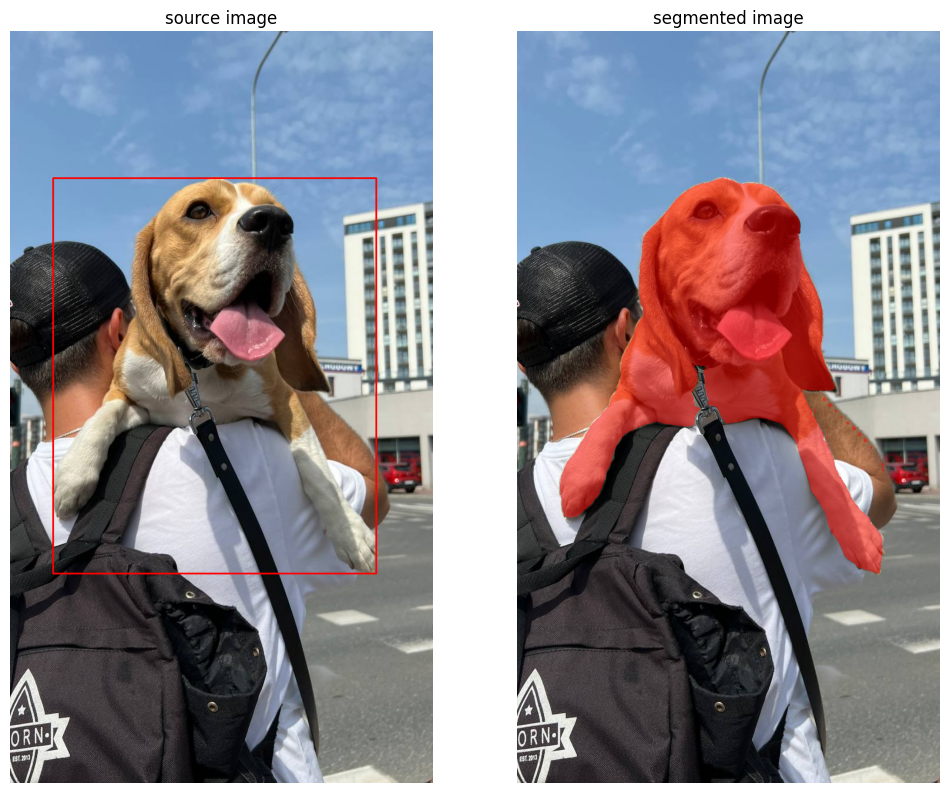

In [34]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
# 'sv.BoxAnnotator(color=sv.Color.red())'를 사용하여 'box_annotator' 객체를 생성
# 박스 주석 기능을 제공하며, 'color' 매개변수를 통해 주석의 색상을 설정
# 여기서는 빨간색을 사용
box_annotator = sv.BoxAnnotator(color=sv.Color.red())

# 'sv.MaskAnnotator(color=sv.Color.red())'를 사용하여 'mask_annotator' 객체를 생성
# 마스크 주석 기능을 제공하며, 'color' 매개변수를 통해 주석의 색상을 설정
# 여기서는 빨간색을 사용
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

# 'sv.Detections' 객체를 생성
# 'sv.Detections'는 감지된 객체의 정보를 담는 클래스
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),   # 'masks'를 'sv.mask_to_xyxy()' 함수를 사용하여 좌표 형식으로 변환한 값으로 설정
    mask=masks     # 'masks'를 그대로 설정
)

# 'detections' 객체에서 'detections.area == np.max(detections.area)'를 사용
# 면적이 가장 큰 객체를 선택
# 'detections.area'는 객체의 면적
# 'np.max(detections.area)'는 최대 면적을 구하는 코드
detections = detections[detections.area == np.max(detections.area)]

# 'image_bgr.copy()'를 사용하여 'image_bgr'의 복사본인 'source_image'를 생성
# 'box_annotator.annotate()' 메서드를 호출하여 'box_annotator'를 사용하여 'source_image'에 박스 주석을 추가
# 'detections'를 사용하여 주석을 추가
# 'skip_label=True'로 설정하여 라벨을 생략
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)

# 'image_bgr.copy()'를 사용하여 'image_bgr'의 복사본인 'segmented_image'를 생성
# 'mask_annotator.annotate()' 메서드를 호출하여 'mask_annotator'를 사용하여 'segmented_image'에 마스크 주석을 추가
# 'detections'를 사용하여 주석을 추가
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# 'sv.plot_images_grid()' 함수를 호출하여 'source_image'와 'segmented_image'를 그리드 형식으로 출력
# 'grid_size=(1, 2)'는 그리드의 크기를 지정
# 'titles=['source image', 'segmented image']'는 각 이미지에 대한 제목을 설정
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## 분할 결과와의 상호 작용

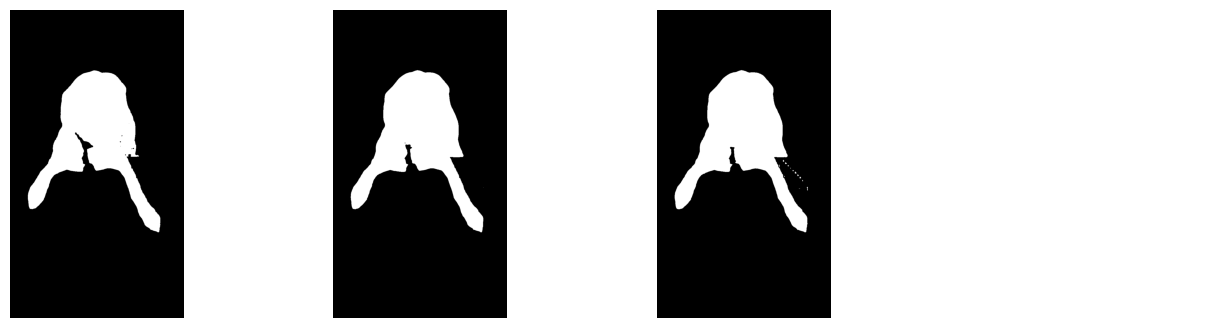

In [35]:
import supervision as sv

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

In [ ]:
import supervision as sv  # 'supervision' 모듈을 'sv'라는 이름으로 import

# 'sv.plot_images_grid()' 함수를 호출하여 'masks'를 그리드 형식으로 출력
sv.plot_images_grid(
    images=masks,       # 'images' 매개변수에는 출력할 이미지들이 포함된 배열 'masks'를 전달
    grid_size=(1, 4),   # 'grid_size=(1, 4)'는 그리드의 크기를 지정, 여기서는 1행 4열의 그리드를 생성
    size=(16, 4)        # 'size=(16, 4)'는 각 이미지의 크기를 지정, 여기서는 가로로 16픽셀, 세로로 4픽셀로 설정
)

## Roboflow Universe 데이터 세트에서 segment anything

- 데이터 세트 처리를 지원하는 유틸리티
    - COCO 주석 처리를 용이하게 하기 위해 직접 작성해야 하는 몇 가지 도우미 함수

In [36]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

In [ ]:
import numpy as np   # 'numpy' 모듈을 'np'라는 이름으로 import
from dataclasses import dataclass   # 'dataclasses' 모듈에서 'dataclass'를 데이터 클래스를 생성하기 위해 사용
from typing import List, Tuple, Union, Optional  # 'typing' 모듈에서 'List', 'Tuple', 'Union', 'Optional'을 타입 힌트를 위해 사용
from dataclasses_json import dataclass_json # 'dataclasses_json' 모듈에서 'dataclass_json'을 데이터 클래스의 JSON 직렬화와 역직렬화를 위해 사용
from supervision import Detections # 'supervision' 모듈에서 'Detections' import

# '@dataclass_json' 데코레이터는 해당 클래스의 인스턴스를 JSON 직렬화할 수 있도록 만들어주는 역할
@dataclass_json
@dataclass
class COCOCategory:    # 'COCOCategory' 클래스는 COCO 데이터셋의 카테고리를 나타내는 데이터 클래스, 'id', 'name', 'supercategory' 세 개의 속성
    id: int            # 카테고리의 고유 식별자로 정수형 데이터
    name: str          # 카테고리의 이름으로 문자열 데이터
    supercategory: str  # 카테고리의 상위 범주를 나타내는 문자열 데이터


@dataclass_json
@dataclass
class COCOImage:   # 'COCOImage' 클래스는 COCO 데이터셋의 이미지를 나타내는 데이터 클래스
    id: int        # 이미지의 고유 식별자로 정수형 데이터
    width: int     # 이미지의 너비로 정수형 데이터
    height: int     # 이미지의 높이로 정수형 데이터
    file_name: str   # 이미지 파일의 이름으로 문자열 데이터
    license: int     # 이미지에 대한 라이선스 정보로 정수형 데이터
    date_captured: str    # 이미지가 캡처된 날짜 정보로 문자열 데이터
    coco_url: Optional[str] = None   # COCO 데이터셋에서 이미지의 URL 정보로 선택적으로 사용되는 문자열 데이터, 기본값은 'None'
    flickr_url: Optional[str] = None  #  Flickr에서 이미지의 URL 정보로 선택적으로 사용되는 문자열 데이터, 기본값은 'None'


@dataclass_json
@dataclass
class COCOAnnotation:    # 'COCOAnnotation' 클래스는 COCO 데이터셋의 주석(Annotation)을 나타내는 데이터 클래스
    id: int              # 주석의 고유 식별자로 정수형 데이터
    image_id: int         # 해당 주석이 속한 이미지의 식별자로 정수형 데이터
    category_id: int      # 주석이 속한 카테고리의 식별자로 정수형 데이터
    segmentation: List[List[float]]    # 주석의 분할 정보를 나타내는 리스트, 각 분할 정보는 좌표(실수형 데이터)를 포함하는 리스트로 구성
    area: float         # 주석이 차지하는 영역의 크기로 실수형 데이터
    bbox: Tuple[float, float, float, float]  # 주석을 둘러싼 경계 상자(Bounding Box)의 좌표 정보를 나타내는 튜플, 경계 상자의 좌상단 x, y 좌표와 폭(width), 높이(height)를 포함하며, 각각은 실수형 데이터
    iscrowd: int      # 주석이 모여있는지 여부를 나타내는 플래그로 정수형 데이터

@dataclass_json
@dataclass
class COCOLicense:    # 'COCOLicense' 클래스는 COCO 데이터셋의 라이선스 정보를 나타내는 데이터 클래스
    id: int           # 라이선스의 고유 식별자로 정수형 데이터
    name: str         # 라이선스의 이름으로 문자열 데이터
    url: str          # 라이선스에 대한 URL 정보로 문자열 데이터


@dataclass_json
@dataclass
class COCOJson:                       # 'COCOJson' 클래스는 COCO 데이터셋을 나타내는 데이터 클래스
    images: List[COCOImage]             # COCO 이미지 정보의 리스트로, 각 이미지는 'COCOImage' 클래스의 인스턴스
    annotations: List[COCOAnnotation]   # COCO 주석 정보의 리스트, 각 주석은 'COCOAnnotation' 클래스의 인스턴스
    categories: List[COCOCategory]      # COCO 카테고리 정보의 리스트로, 각 카테고리는 'COCOCategory' 클래스의 인스턴스
    licenses: List[COCOLicense]         # COCO 라이선스 정보의 리스트로, 각 라이선스는 'COCOLicense' 클래스의 인스턴스


def load_coco_json(json_file: str) -> COCOJson:  # 'load_coco_json' 함수는 COCO 형식의 JSON 파일을 로드하여 'COCOJson' 객체로 반환
    import json   # 'json' 모듈 import

    with open(json_file, "r") as f:   # 주어진 'json_file' 경로의 파일을 읽기 모드로 열기
        json_data = json.load(f)      # 'json.load(f)'를 사용하여 JSON 파일의 데이터를 읽어오기

    return COCOJson.from_dict(json_data)   # 읽어온 JSON 데이터를 'COCOJson.from.dict(json_data)'로 변환하여 'COCOJson' 객체를 생성하고 'COCOJson' 객체를 반환


class COCOJsonUtility:   # 'COCOJsonUtility' 클래스는 COCO 데이터셋을 다루는 유틸리티 함수들을 제공하는 클래스
    @staticmethod  # 정적(static) 메서드

    # 이미지 ID를 기반으로 COCOJson 객체에서 해당 이미지에 대한 주석(annotation)들을 가져오는 메서드
    # 반환값은 'List[COCOAnnotation]' 형태
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    # 이미지 경로를 기반으로 COCOJson 객체에서 해당 이미지에 대한 주석들을 가져오는 메서드
    # 이미지 경로에 해당하는 이미지를 get_image_by_path 메서드를 통해 검색한 후,
    # 해당 이미지의 ID를 사용하여 get_annotations_by_image_id 메서드를 호출
    # 반환값은 'Optional[List[COCOAnnotation]]' 형태
    # 이미지를 찾지 못한 경우 'None'을 반환
    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    # 이미지 경로를 기반으로 COCOJson 객체에서 해당 이미지를 가져오는 메서드
    # 이미지 경로와 일치하는 이미지를 COCOJson 객체의 'images' 속성에서 검색하여 반환
    # 반환값은 'Optional[COCOImage]' 형태
    # 이미지를 찾지 못한 경우 None을 반환
    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    # COCO 주석(annotation)들을 Supervision 라이브러리의 'Detections' 객체로 변환하는 메서드
    # 입력으로 받은 'List[COCOAnnotation]'에 대해
    # 각 주석의 경계 상자(bbox) 정보와 카테고리 ID를 추출하여 Detections 객체로 변환
    # 반환값은 'Detections' 객체
    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

## Roboflow에서 데이터 세트 다운로드

In [41]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("hashira-fhxpj").project("mri-brain-tumor")
dataset = project.version(1).download("coco")

/content
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to MRI-BRAIN-TUMOR-1 in coco:: 100%|██████████| 85/85 [00:00<00:00, 2313.30it/s]


In [ ]:
# Roboflow를 사용하여 MRI 뇌 종양 데이터 셋을 다운로드하는 작업수행

%cd {HOME}   # 'HOME' 디렉토리로 변경

import roboflow   # 'roboflow' 모듈 import
from roboflow import Roboflow   # 'roboflow' 라이브러리에서 'Roboflow' 클래스를 import

roboflow.login()  # Roboflow 계정에 로그인, API로 접속

rf = Roboflow()  # 'Roboflow' 클래스의 인스턴스인 'rf'를 생성

# 'rf' 인스턴스를 통해 Roboflow 워크스페이스 및 프로젝트에 액세스
# "hashira-fhxpj"는 워크스페이스의 식별자이고, "mri-brain-tumor"는 프로젝트의 식별자
# 이 식별자는 Roboflow 플랫폼에서 해당 워크스페이스 및 프로젝트에 대한 정보
project = rf.workspace("hashira-fhxpj").project("mri-brain-tumor")


# 'project' 변수를 통해 특정 버전(여기서는 버전 1)의 데이터셋을 COCO 형식으로 다운로드
# 'download' 메서드는 Roboflow 플랫폼에서 데이터셋을 다운로드 후 'dataset' 변수에 저장
dataset = project.version(1).download("coco")

In [49]:
# roboflow에 접속하는 다른 방법

%cd {HOME}
from roboflow import Roboflow

rf = Roboflow(api_key="rY0TX5glzBw6wPMBMjH7")

project = rf.workspace("class-glndb").project("braintumor-fad4x")
dataset = project.version(2).download("coco")

/content
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to braintumor-2 in coco:: 100%|██████████| 198/198 [00:00<00:00, 1724.53it/s]


In [ ]:
# roboflow에 접속하는 다른 방법

%cd {HOME}   # 주어진 경로(HOME)로 현재 작업 디렉토리를 변경하는 명령

# roboflow 라이브러리에서 Roboflow 클래스를 가져오는 명령
from roboflow import Roboflow

# Roboflow 클래스의 인스턴스를 생성하고, API 키를 인자로 전달하여 초기화
rf = Roboflow(api_key="rY0TX5glzBw6wPMBMjH7")

# 'rf' 인스턴스를 통해 Roboflow 워크스페이스 및 프로젝트에 액세스
# "class-glndb"는 워크스페이스의 식별자이고, "braintumor-fad4x"는 프로젝트의 식별자
# 이 식별자는 Roboflow 플랫폼에서 해당 워크스페이스 및 프로젝트에 대한 정보
project = rf.workspace("class-glndb").project("braintumor-fad4x")

# 'project' 변수를 통해 특정 버전(여기서는 버전 2)의 데이터셋을 COCO 형식으로 다운로드
# 'download' 메서드는 Roboflow 플랫폼에서 데이터셋을 다운로드 후 'dataset' 변수에 저장
dataset = project.version(2).download("coco")

In [51]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [ ]:
import os  # 'os' 모듈 import

DATA_SET_SUBDIRECTORY = "test"  # 데이터셋의 하위 디렉토리 이름을 "test"로 지정

ANNOTATIONS_FILE_NAME = "_annotations.coco.json"  # 주석 파일의 이름을 "_annotations.coco.json"로 지정

# 이미지 디렉토리의 경로를 생성
# 'os.path.join()' 함수를 사용하여 'dataset.location' (데이터셋 위치)과 'DATA_SET_SUBDIRECTORY' (하위 디렉토리 이름)를 결합
# 이미지 디렉토리의 전체 경로를 생성
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)

# 주석 파일의 경로를 생성
# 'os.path.join()' 함수를 사용하여 'dataset.location' (데이터셋 위치), 'DATA_SET_SUBDIRECTORY' (하위 디렉토리 이름)
# 및 ANNOTATIONS_FILE_NAME (주석 파일 이름)을 결합하여
# 주석 파일의 전체 경로를 생성
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [52]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [ ]:
# 'load_coco_json' 함수를 사용하여 COCO 형식의 주석 파일을 로드
# 'ANNOTATIONS_FILE_PATH' 변수는 이전에 생성된 주석 파일의 경로
# 로드된 데이터는 'coco_data' 변수에 저장
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

# COCO 데이터셋의 카테고리 정보에서 "supercategory"가 'none'이 아닌 클래스들의 이름을 추출하여 리스트 CLASSES에 저장
CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

# COCO 데이터셋의 이미지 정보에서 파일 이름을 추출하여 리스트 'IMAGES'에 저장하는 부분
# 리스트 컴프리헨션을 사용하여 각 이미지의 파일 이름 불러오기
IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [44]:
CLASSES

['YES-TUMOR']

## 마스크 단일 이미지 경계 상자

In [45]:
import random
random.seed(10)

In [47]:
# set random seed to allow easy reproduction of the experiment

import random   # 'random' 모듈 import
random.seed(10)  # 'random' 모듈의 시드(seed)를 설정하는 부분
                 # 시드 값으로 10을 사용 - 난수 생성기의 초기값으로 10을 사용

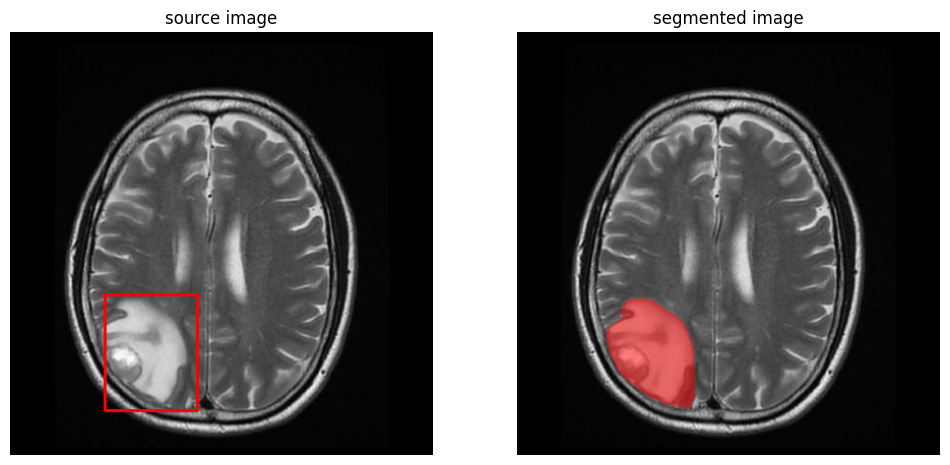

In [48]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

ground_truth.class_id = ground_truth.class_id - 1

image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth, skip_label=True)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
# 'IMAGES' 리스트에서 임의의 이미지 이름을 선택하여 'EXAMPLE_IMAGE_NAME' 변수에 할당하는 부분
# 'random.choice()' 함수는 주어진 시퀀스에서 임의의 요소를 선택하는 함수
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)

# 'EXAMPLE_IMAGE_NAME'을 사용하여 이미지의 전체 경로를 생성하는 부분
# 'os.path.join()' 함수는 여러 개의 경로 요소를 전달받아, 해당 운영 체제에 맞게 경로를 조합하여 반환하는 함수
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# COCOJsonUtility라는 클래스의 get_annotations_by_image_path 메서드를 사용하여
# 주어진 이미지에 대한 주석(annotation) 정보를 가져오는 부분
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)

# COCOJsonUtility 클래스의 annotations2detections 메서드를 사용하여
# 주어진 주석(annotation) 정보를 detection 정보로 변환하여 ground_truth 변수에 할당하는 부분
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# ground_truth 객체의 class_id 속성에 저장된 클래스 ID를 1씩 감소시키는 부분
ground_truth.class_id = ground_truth.class_id - 1

# OpenCV를 사용하여 BGR 형식으로 이미지를 읽어오는 부분
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)

# BGR(Blue-Green-Red) 형식의 이미지를 RGB(Red-Green-Blue) 형식으로 변환하는 부분
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# 'BoxAnnotator'는 주석 상자를 추가하는 데 사용
# 'sv.Color.red()'를 사용하여 빨간색으로 지정
box_annotator = sv.BoxAnnotator(color=sv.Color.red())

# 'MaskAnnotator'는 주석 마스크를 추가하는 데 사용
# 'sv.Color.red()'를 사용하여 빨간색으로 지정
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

# 'box_annotator' 객체를 사용하여 BGR 형식의 이미지에 상자 주석을 추가하는 부분
# 'annotate' 메서드를 호출하여 상자 주석이 추가된 이미지를 생성
# 'scene' 매개변수에는 주석을 추가할 이미지인 'image_bgr.copy()'가 전달
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth, skip_label=True)

# 'mask_predictor' 객체의 'set_image' 메서드를 호출하여 이미지를 설정하는 부분
# 'set_image' 메서드는 'mask_predictor' 객체에 이미지를 설정하여 이후에 마스크 예측을 수행할 때 사용
mask_predictor.set_image(image_rgb)

# 'mask_predictor' 객체의 'predict' 메서드를 호출하여 마스크 예측을 수행하는 부분
# 'box' 매개변수는 예측할 마스크에 대한 바운딩 박스 정보를 전달
# 'ground_truth.xyxy[0]'가 주어졌고, ground_truth는 객체의 위치 정보를 나타내며,
# .xyxy는 객체의 경계 상자를 나타내는 정보입니다.
 # [0]는 첫 번째 객체의 정보를 의미
masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

# 'sv.Detections' 객체를 생성하는 부분
# 'sv.Detections'는 검출된 객체에 대한 정보를 담고 있는 클래스
# 'xyxy' 매개변수는 마스크로부터 얻은 바운딩 박스 정보
# 'sv.mask_to_xyxy' 함수를 사용하여 'masks'를 바운딩 박스 형식으로 변환
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks   # 예측된 마스크 정보
)

# 'detections' 객체에서 면적이 가장 큰 객체(영역)에 대한 정보를 선택하는 부분
# 'detections.area'는 'detections' 객체의 면적 정보
# 'np.max(detections.area)'는 'detections' 객체의 면적 중 가장 큰 값
detections = detections[detections.area == np.max(detections.area)]

# 'mask_annotator' 객체를 사용하여 BGR 형식의 이미지에 마스크 주석을 추가하는 부분
# 'annotate' 메서드를 호출하여 마스크 주석이 추가된 이미지를 생성
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# 'sv.plot_images_grid' 함수를 사용하여 이미지 그리드를 생성하는 부분
sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],  # 'images' 매개변수에는 표시할 이미지들을 리스트로 전달
    grid_size=(1, 2),  # 'grid_size' 매개변수는 그리드의 행과 열 개수를 지정
    titles=['source image', 'segmented image']  # 'titles' 매개변수는 각 이미지에 대한 제목을 리스트로 전달
)